# 1. Installing machine learning libraries

In [1]:
#!pip install imblearn

In [2]:
#!pip install lightgbm

In [3]:
!pip install pipeline

  Could not find a version that satisfies the requirement pipeline (from versions: )
No matching distribution found for pipeline
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# 2. Importing libraries

In [9]:
import pandas as pd
from imblearn.over_sampling import ADASYN, SMOTE
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
#from sklearn.pipeline import PipeLine
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve,precision_recall_curve, precision_score, confusion_matrix, classification_report

# 3. Modeling

Several baseline models are created with different preprocessing techniques in order to arrive at the best performing one. 

### Model 1 - With label encoding and weather variables

This model uses the LightGBM classifier and adopts the label encoding method for handling categorical variables. This model also includes the weather variables. Since these variables contained more than 30,000 unknown values and did not provide much insight with respect to explaining the variability between the severity classes, we will try another model later with these features excluded. 

In [156]:
#Loading in the cleaned dataset
df = pd.read_csv('df_binary.csv')

### Pre-processing

We first remove the variables which we are not going to use in our model. These are variables that only provide information about the collision incident once it has occurred such as *Number of People Involved* and *SDOT Collision Description*. Hence they cannot be used for predicting the severity of future collisions. This is done using the *.drop* dataframe function, leaving us with 13 remaining variables to train our model on. 

In [157]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Date','Collision Type','Unnamed: 0','Num People Square'],axis=1)

df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Day of the Week
0,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Daylight,12,15,48.0,2.36674,0.56104,Riverton,Wednesday
1,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,85.0,-1.00000,0.36276,Seattle,Sunday
2,Block,Not Severe,Mid-Block (not related to intersection),Overcast,Dry,Daylight,12,13,13.0,-1.00000,0.36276,Seattle,Monday
3,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,58.0,0.00000,1.73291,Seattle,Thursday
4,Block,Not Severe,Mid-Block (not related to intersection),Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,17,55.0,1.57819,0.74738,White Center,Friday


Next, we pre-process the categorical variables by converting their values to discrete integers which makes it easier to handle for modeling algorithms. This is done using the *LabelEncoder* function of the *sklearn* machine learning library in Python. 

In [158]:
#Label encoding all the categorical variables
le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Weather'] = le.fit_transform(df_binary_base_model['Weather'])
df_binary_base_model['Road Condition'] = le.fit_transform(df_binary_base_model['Road Condition'])
df_binary_base_model['Light Condition'] = le.fit_transform(df_binary_base_model['Light Condition'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))

df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Day of the Week
0,0,0,4,2,3,2,3,7,48.0,2.36674,0.56104,7,6
1,0,0,4,2,3,1,3,12,85.0,-1.00000,0.36276,8,3
2,0,0,4,1,0,2,3,5,13.0,-1.00000,0.36276,8,1
3,0,0,4,2,3,1,3,12,58.0,0.00000,1.73291,8,4
4,0,0,4,0,0,1,3,9,55.0,1.57819,0.74738,11,0


Following the label encoding, we can confirm that the pre-processing took effect by looking at the table above that contain discrete numerical values for the categorical variables. 

Below, we split the data into the explanatory variables and the target variable. To get the explanatory variables, the *Severity Description* variable is simply dropped from the dataset using the *.drop* dataframe function from pandas. The target variable is extracted by just selecting the *Severity Description* column from the main dataset using regular dataframe column indexing. The two variables are called *X and Y*. 

The shape of the resulting independent variables (X) is verified to be **204,908 by 13** whereas the shape of the target variable (Y) only reads 204,908 which indicates that it's a **Series object of length 204,908** which is what we want. 

In [159]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204908, 12)
(204908,)


### Train test split

Next, the two datasets are further split into train and test samples. The train samples are used to train the model while the test sample is used to evaluate the model. In this case, set the train size to be 70% of the original size. Therefore, following the split, the train samples have a length of 143,435 and the test samples have a length of 61,473 which makes sense. 

In [160]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (x_train.head())

(143435, 12)
(61473, 12)
(143435,)
(61473,)
        Address Type  Junction Type  Weather  Road Condition  Light Condition  \
7356               1              1        0               0                2   
115275             1              1        0               0                2   
125588             0              4        4               2                4   
166522             1              1        0               0                2   
18389              0              4        0               0                2   

        Month  Hour  Speed  Road Congestion  Road Length  Neighborhood  \
7356        7     7   20.0         -1.00000      0.36276             8   
115275      6     9   53.0          2.80507      0.38026             8   
125588      3     0   58.0          2.35247      0.63395             8   
166522      6     7   41.0         -1.00000      1.24014             9   
18389      10     0   73.0          2.36674      0.56104             0   

        Day of the Week 

### Oversampling the minority class using Synthetic Minortiy Oversampling Technique (SMOTE)

Due to the severe class only representing ~1.5% of the data, we use an oversampling method to create more synthetic data points similar to the severe instances, making the representation of the two classes nearly the same.

In [161]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141175), (1, 141175)]


### Modeling and prediction

Below we fit the *x_train* and *y_train* data with the light GBM classifier and do our prediction using *x_test*. 

In [162]:
lgb = LGBMClassifier()
model = lgb.fit(x_resampled,y_resampled)
prediction = model.predict(x_test)

### Model evaluation

For evaluating the model, we use accuracy, precision, recall, and roc_auc as the main metrics. 

In the first step, these values are directly calculated by importing these metric functions from the *sklearn.metrics* library and using them to compare the y_test sample and the predicted values. Another way of quickly getting these values is by using the *classification_report* function. Although, the classification report does not show the accuracy and roc_auc scores. 

In [163]:
acc = accuracy_score(y_test,prediction)
print ("Accuracy: ",acc)
prc = precision_score(y_test,prediction,average='micro')
print ("Precision: ",prc)
rec = recall_score(y_test,prediction,average='micro')
print ("Recall: ",rec)
f1 = f1_score(y_test,prediction,average='micro')
print ("F1 score: ",f1)
auc = roc_auc_score(y_test,prediction)
print ("Combined AUC score: ",auc)
print ()
print ("Distribution of severity classes in y_test sample")
print (pd.Series(y_test).value_counts())
print ()
print ("Distribution of severity class in predicted sample")
print (pd.Series(prediction).value_counts())

Accuracy:  0.9842044474810079
Precision:  0.9842044474810079
Recall:  0.9842044474810079
F1 score:  0.9842044474810079
Combined AUC score:  0.4999917359469778

Distribution of severity classes in y_test sample
0    60503
1      970
Name: Severity Description, dtype: int64

Distribution of severity class in predicted sample
0    61472
1        1
dtype: int64


In [17]:
class_report = classification_report(list(y_test),list(prediction))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
print (class_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     60503
           1       0.00      0.00      0.00       970

    accuracy                           0.98     61473
   macro avg       0.49      0.50      0.50     61473
weighted avg       0.97      0.98      0.98     61473



In [166]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60502 1 970 0


In [167]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

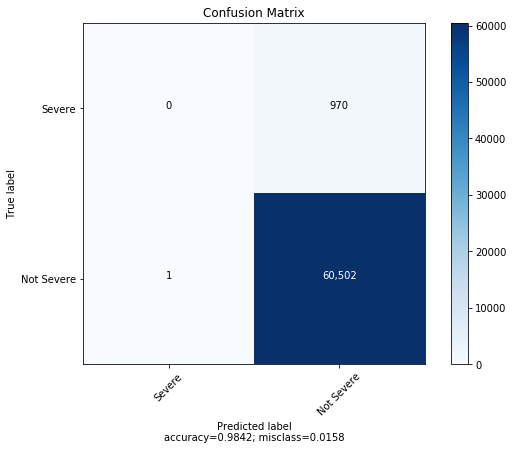

In [172]:
plot_confusion_matrix(cm           = np.array([[ tp,  fn],
                                              [  fp, tn]]), 
                      normalize    = False,
                      target_names = ['Severe', 'Not Severe'],
                      title        = "Confusion Matrix")

A first look at the results reveals the accuracy score to be 0.9842. The precision, recall and f1-score values are the same as well. Initially, these values looked great but determining the roc_auc score told a different story. 

Below, we generate the roc_auc score as well as generate the curve for it using the true positive rate (sensitivity) and false positive rate. 

### Generating the ROC AUC curve

First we make predictions using the x_test data once again but this using the *.predict_proba* function instead of the *.predict* function. This function returns all the predicted probabilities for each instance for each severity class. If the probability for a certain class is greater than the threshold value (default is 0.5), that class is predicted for that instance. 

The roc_auc score for the severe class can be calculating by applying the roc_auc scoring function to the *y_test* sample and the severe class probabilities. This is the metric that we want. In this case, the roc_auc score comes out to be 0.677. Ideally, this score would be significantly higher but the class imbalance issue is causing the score to be this low. 

Combined ROC AUC=0.500
Severe class ROC AUC=0.654
Not severe class ROC AUC=0.346


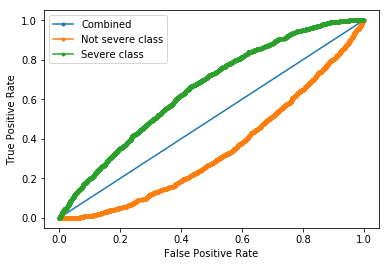

In [164]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

The plot shown above displays the auc curves for both the severe and non-severe classes as well as the combined auc which is the diagonal through the middle of the chart. Ideally, the severe curve would be pulled more to the top left since this area represents the highest true positive rate and the lowest false positive rate. 

Moving along the curve corresponds to changing our threshold value for the predictions. Therefore, depending on the application, different thresholds can be set in order to achieve a certain specification. For example, increasing the threshold increases both the TPR and FPR so that would be a tradeoff that needs to be considered. 

### Changing thresholds

We have observed that oversampling our minority class does not solve the imbalance issue which is expected since such techniques only work best when the baseline model is already robust to begin with. In this case, due to imbalance the features are not able to differentiate between the severe and non-severe classes that well. 

Hence, we use the threshold values to enhance the metric that is most crucial. In our case, the most important metric is the number of true positive events. Before we proceed let's define some of these important metrics within our context. 

- True positive: Predicting a severe collision when it is actually severe
- False positive: Predicting severe when collision is non-severe
- True negative: Predicting non-severe when it is non-severe
- False negative: Predicting negative when it is positive

Below, we sweep the threshold values across 0 to 1 with a step size of 0.01 to visualize the change in the above metrics. This can help use determine an ideal threshold value for our application. 

In [25]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

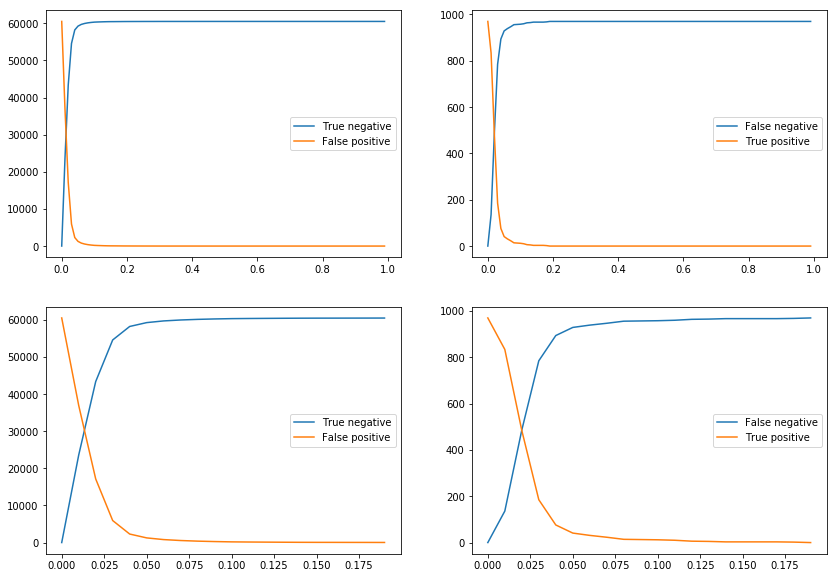

In [26]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

Looking at the plots above, the number of true positives increase and false negatives decrease with decreasing threshold. Also, it seems like we start to see significant increases in TP values only at a threshold of less than 0.1. At about 0.04, the TP and FN are the same. 

The trend is same for TN and FP. The interesting thing to note here is that as we decrease the threshold, our accuracy decreases while our AUC remains the same as we are just moving along the AUC curve. As threshold decreases, events go from TN to FP whereby decreasing the accuracy and increasing the misclassification error. Similarly, values are going from FN to TP. In our application where detecting severe collisions is the most important criteria, this is a fair tradeoff to consider. 

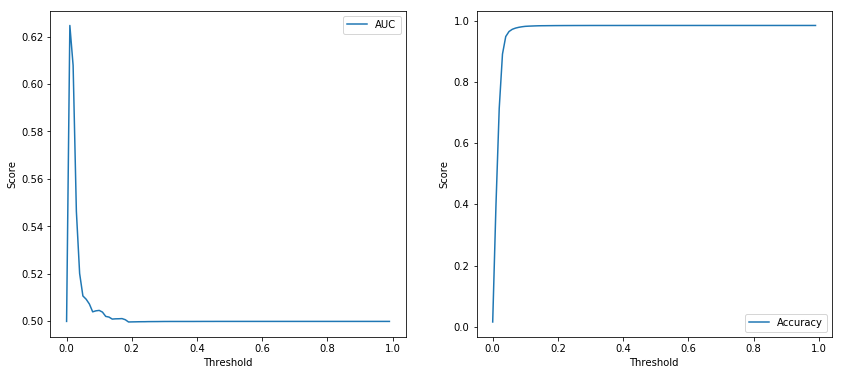

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

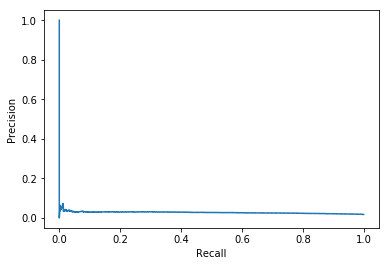

In [28]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [93]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60503 0 970 0


            Feature  Importance
5             Month         553
6              Hour         467
11  Day of the Week         420
7             Speed         267
9       Road Length         266
10     Neighborhood         224
2           Weather         193
4   Light Condition         187
8   Road Congestion         148
1     Junction Type         108
0      Address Type          85
3    Road Condition          82


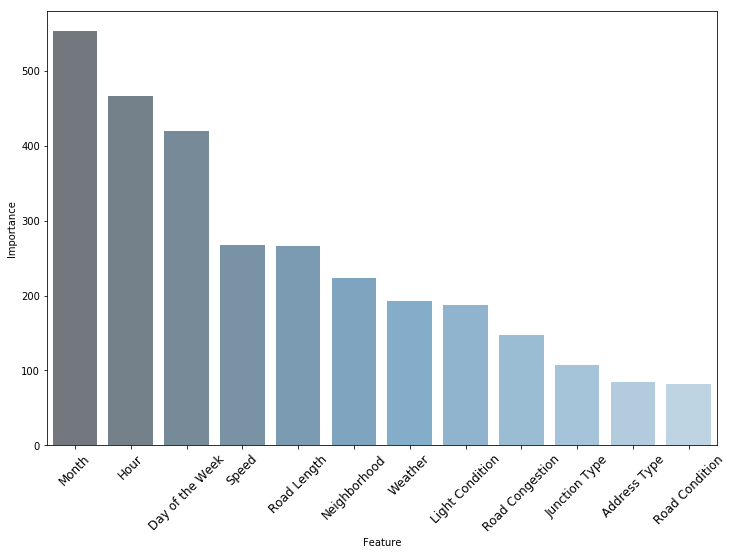

In [165]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(12,8))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.xticks(rotation=45,size=12)
plt.show()

### Model 2 - LightGBM with label encoding | excluding weather variables and neighborhood

This model provided the best severe class AUC: 0.654

Variables included: 
- Address Type
- Junction Type
- Month 
- Date
- Hour
- Speed
- Road Congestion
- Road Length
- Day of the Week

(204783, 9)
(204783,)
(143348, 9)
(61435, 9)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021
[(0, 141086), (1, 141086)]
Accuracy:  0.9842597867665012
Precision:  0.9842597867665012
Recall:  0.9842597867665012
F1 score:  0.9842597867665012
Combined AUC score:  0.5

Distribution of severity classes in y_test sample
0    60468
1      967
Name: Severity Description, dtype: int64

Distribution of severity class in predicted sample
0    61435
dtype: int64
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.654
Not severe class ROC AUC=0.346


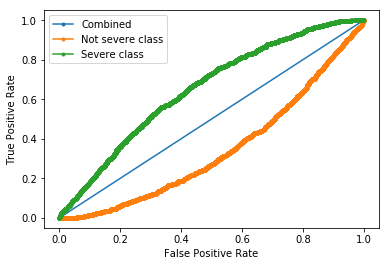

In [2]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))
'''
# Normalizing continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(x_resampled)
x_resampled_norm = scaler.transform(x_resampled)
x_test = scaler.transform(x_test)
'''

lgb = LGBMClassifier()
model = lgb.fit(x_resampled,y_resampled)
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print ("Accuracy: ",acc)
prc = precision_score(y_test,prediction,average='micro')
print ("Precision: ",prc)
rec = recall_score(y_test,prediction,average='micro')
print ("Recall: ",rec)
f1 = f1_score(y_test,prediction,average='micro')
print ("F1 score: ",f1)
auc = roc_auc_score(y_test,prediction)
print ("Combined AUC score: ",auc)
print ()
print ("Distribution of severity classes in y_test sample")
print (pd.Series(y_test).value_counts())
print ()
print ("Distribution of severity class in predicted sample")
print (pd.Series(prediction).value_counts())

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))

tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Oversampling using SMOTE actually yielded a ROC AUC score of 0.627 where without oversampling the score was 0.654. 

#### Changing thresholds

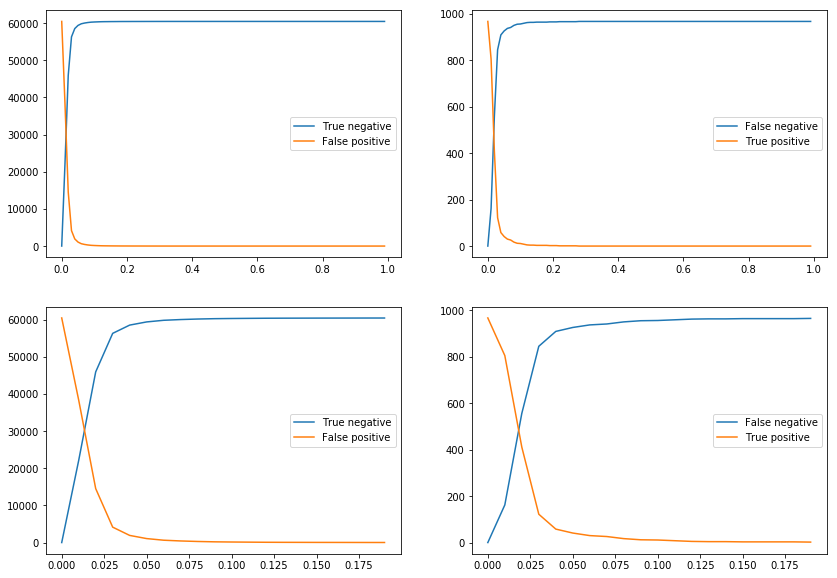

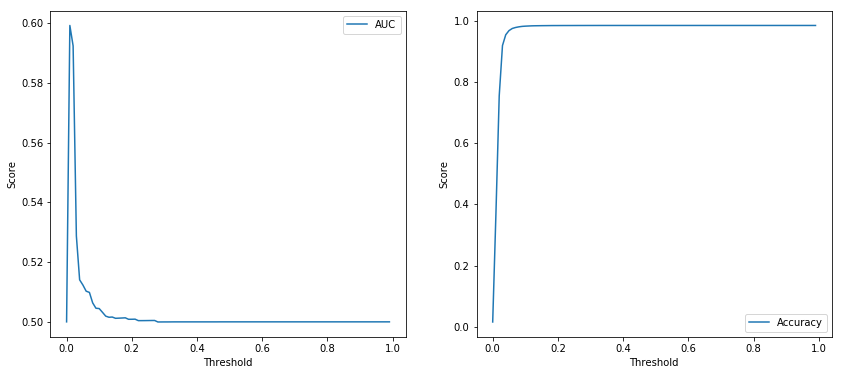

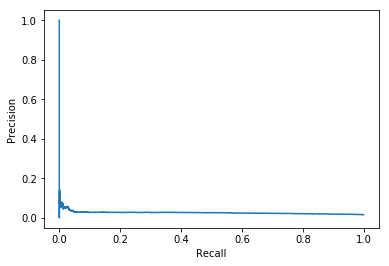

           Feature  Importance
5            Speed         533
7      Road Length         461
3             Date         433
4             Hour         414
6  Road Congestion         386
2            Month         325
8  Day of the Week         252
1    Junction Type         162
0     Address Type          34


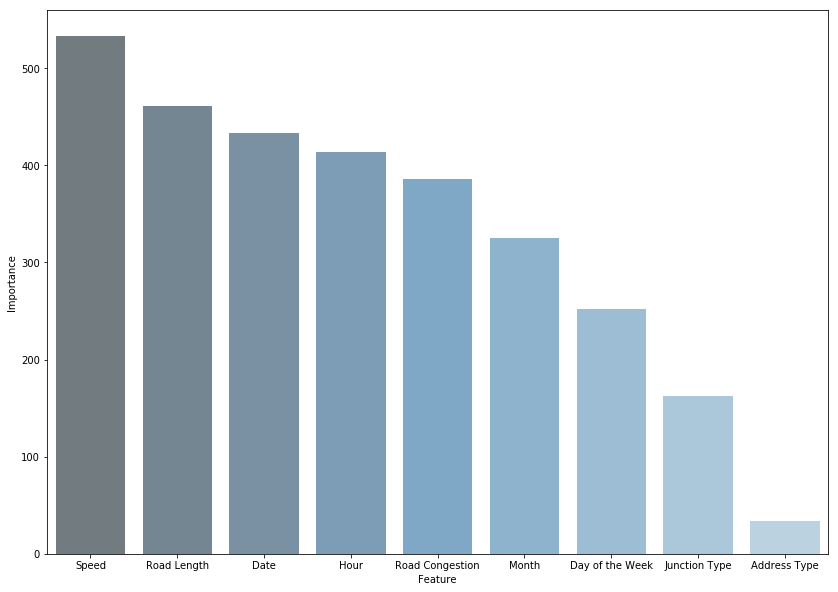

In [155]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.title('ROC AUC vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

### Model 3 - With one hot encoding and without weather variables

In [35]:
df = pd.read_csv('df_binary.csv')

In [36]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Date','Collision Type','Unnamed: 0','Num People Square'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Address Type,Severity Description,Junction Type,Weather,Road Condition,Light Condition,Month,Hour,Speed,Road Congestion,Road Length,Neighborhood,Day of the Week
0,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Daylight,12,15,48.0,2.36674,0.56104,Riverton,Wednesday
1,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,85.0,-1.00000,0.36276,Seattle,Sunday
2,Block,Not Severe,Mid-Block (not related to intersection),Overcast,Dry,Daylight,12,13,13.0,-1.00000,0.36276,Seattle,Monday
3,Block,Not Severe,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,12,2,58.0,0.00000,1.73291,Seattle,Thursday
4,Block,Not Severe,Mid-Block (not related to intersection),Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,17,55.0,1.57819,0.74738,White Center,Friday


In [37]:
#One hot encoding
df_ohe = pd.concat((df_binary_base_model[['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Severity Description']],
          pd.get_dummies(df_binary_base_model, columns=['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Severity Description'], drop_first=True)),
          axis=1)
df_ohe.head()

,Address Type,Junction Type,Month,Hour,Neighborhood,Day of the Week,Severity Description,Weather,Road Condition,Light Condition,...,Neighborhood_Tukwila,Neighborhood_White Center,Neighborhood_Yarrow Point,Day of the Week_Monday,Day of the Week_Saturday,Day of the Week_Sunday,Day of the Week_Thursday,Day of the Week_Tuesday,Day of the Week_Wednesday,Severity Description_Severe
0,Block,Mid-Block (not related to intersection),12,15,Riverton,Wednesday,Not Severe,Raining,Wet,Daylight,...,0,0,0,0,0,0,0,0,1,0
1,Block,Mid-Block (not related to intersection),12,2,Seattle,Sunday,Not Severe,Raining,Wet,Dark - Street Lights On,...,0,0,0,0,0,1,0,0,0,0
2,Block,Mid-Block (not related to intersection),12,13,Seattle,Monday,Not Severe,Overcast,Dry,Daylight,...,0,0,0,1,0,0,0,0,0,0
3,Block,Mid-Block (not related to intersection),12,2,Seattle,Thursday,Not Severe,Raining,Wet,Dark - Street Lights On,...,0,0,0,0,0,0,1,0,0,0
4,Block,Mid-Block (not related to intersection),12,17,White Center,Friday,Not Severe,Clear or Partly Cloudy,Dry,Dark - Street Lights On,...,0,1,0,0,0,0,0,0,0,0


In [38]:
df_ohe = df_ohe.drop(['Address Type','Junction Type','Month','Hour',
                                       'Neighborhood','Day of the Week','Weather',
                          'Road Condition','Light Condition','Severity Description'],axis=1)
df_ohe.head()

,Speed,Road Congestion,Road Length,Address Type_Intersection,Junction Type_At Intersection (intersection related),Junction Type_Driveway Junction,Junction Type_Mid-Block (but intersection related),Junction Type_Mid-Block (not related to intersection),Junction Type_Ramp Junction,Junction Type_Unknown,...,Neighborhood_Tukwila,Neighborhood_White Center,Neighborhood_Yarrow Point,Day of the Week_Monday,Day of the Week_Saturday,Day of the Week_Sunday,Day of the Week_Thursday,Day of the Week_Tuesday,Day of the Week_Wednesday,Severity Description_Severe
0,48.0,2.36674,0.56104,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,85.0,-1.00000,0.36276,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,13.0,-1.00000,0.36276,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,58.0,0.00000,1.73291,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,55.0,1.57819,0.74738,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [39]:
X = df_ohe.drop('Severity Description_Severe',axis=1)
Y = df_ohe['Severity Description_Severe']
print (X.shape)
print (Y.shape)

(204783, 62)
(204783,)


In [40]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.33,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(137204, 62)
(67579, 62)
(137204,)
(67579,)


In [41]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 135038), (1, 135038)]


In [42]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [43]:
acc = accuracy_score(y_test,prediction)
print ("Accuracy: ",acc)
prc = precision_score(y_test,prediction,average='micro')
print ("Precision: ",prc)
rec = recall_score(y_test,prediction,average='micro')
print ("Recall: ",rec)
f1 = f1_score(y_test,prediction,average='micro')
print ("F1 score: ",f1)
auc = roc_auc_score(y_test,prediction)
print ("Combined AUC score: ",auc)
print ()
print ("Distribution of severity classes in y_test sample")
print (pd.Series(y_test).value_counts())
print ()
print ("Distribution of severity class in predicted sample")
print (pd.Series(prediction).value_counts())

Accuracy:  0.984270261471759
Precision:  0.984270261471759
Recall:  0.984270261471759
F1 score:  0.984270261471759
Combined AUC score:  0.5

Distribution of severity classes in y_test sample
0    66516
1     1063
Name: Severity Description_Severe, dtype: int64

Distribution of severity class in predicted sample
0    67579
dtype: int64


In [78]:
class_report = classification_report(list(y_test),list(prediction))

In [79]:
print (class_report)

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     66565
      Severe       0.00      0.00      0.00      1055

    accuracy                           0.98     67620
   macro avg       0.49      0.50      0.50     67620
weighted avg       0.97      0.98      0.98     67620



Combined ROC AUC=0.500
Severe class ROC AUC=0.635
Not severe class ROC AUC=0.365


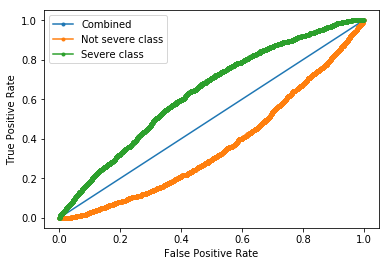

In [44]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [74]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

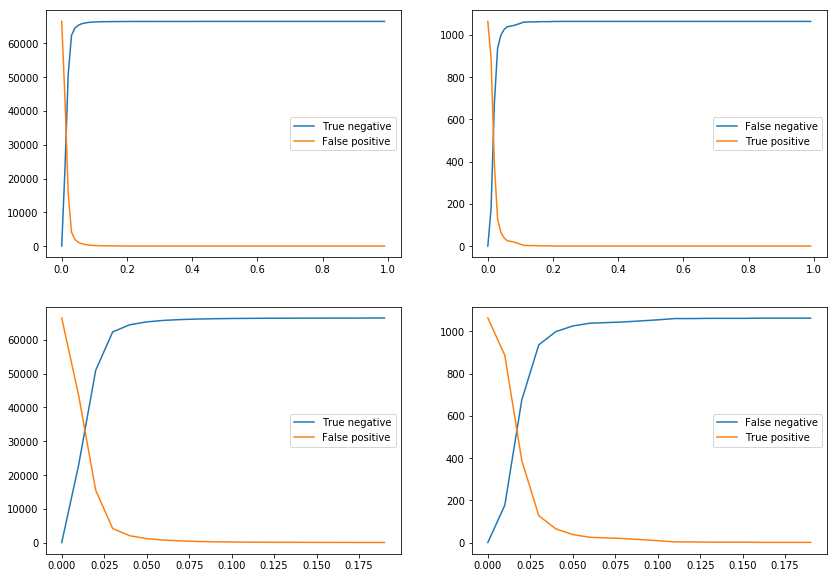

In [75]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

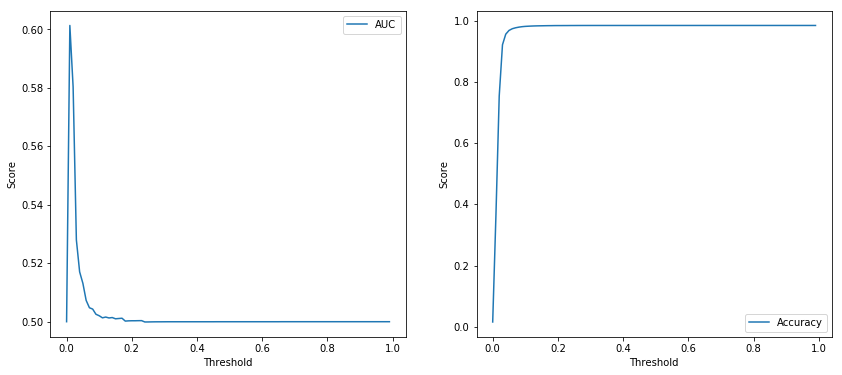

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

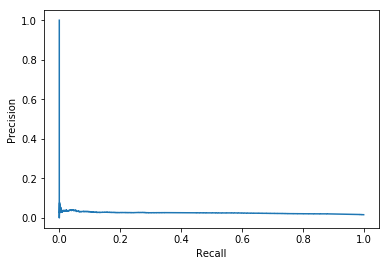

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Results using one hot encoding is actually slightly worse than that with label encoding. Therefore, for subsequent iterations of the model, we will only adopt label encoding. 

### Model 4 - Only Junction Type and Address Type 

In [198]:
df = pd.read_csv('df_binary.csv')

### Pre-processing

We first remove the variables which we are not going to use in our model. These are variables that only provide information about the collision incident once it has occurred. Hence they cannot be used for predicting the severity of future collisions. 

In [107]:
df_binary_base_model = df[['Severity Description','Junction Type','Address Type']]
#df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Junction Type,Address Type
0,Not Severe,Mid-Block (not related to intersection),Block
1,Not Severe,Mid-Block (not related to intersection),Block
2,Not Severe,Mid-Block (not related to intersection),Block
3,Not Severe,Mid-Block (not related to intersection),Block
4,Not Severe,Mid-Block (not related to intersection),Block


In [108]:
le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'])

df_binary_base_model.head()

,Severity Description,Junction Type,Address Type
0,0,4,0
1,0,4,0
2,0,4,0
3,0,4,0
4,0,4,0


In [109]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(205394, 2)
(205394,)


In [110]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(143775, 2)
(61619, 2)
(143775,)
(61619,)


In [106]:
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141495), (1, 141495)]


In [111]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [112]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
#auc = roc_auc_score(y_test,prediction,average=None)
#print (auc)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9845015336178776
0.9845015336178776
0.9845015336178776
0.9845015336178776


0    61619
dtype: int64

In [99]:
class_report = classification_report(list(y_test),list(prediction))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
print (class_report)

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60664
      Severe       0.00      0.00      0.00       955

    accuracy                           0.98     61619
   macro avg       0.49      0.50      0.50     61619
weighted avg       0.97      0.98      0.98     61619



In [113]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.603
Not severe class ROC AUC=0.397


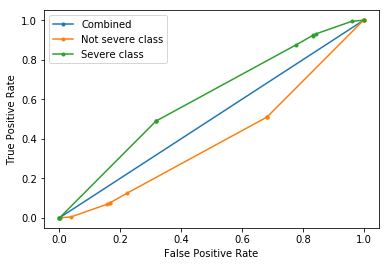

In [114]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [115]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

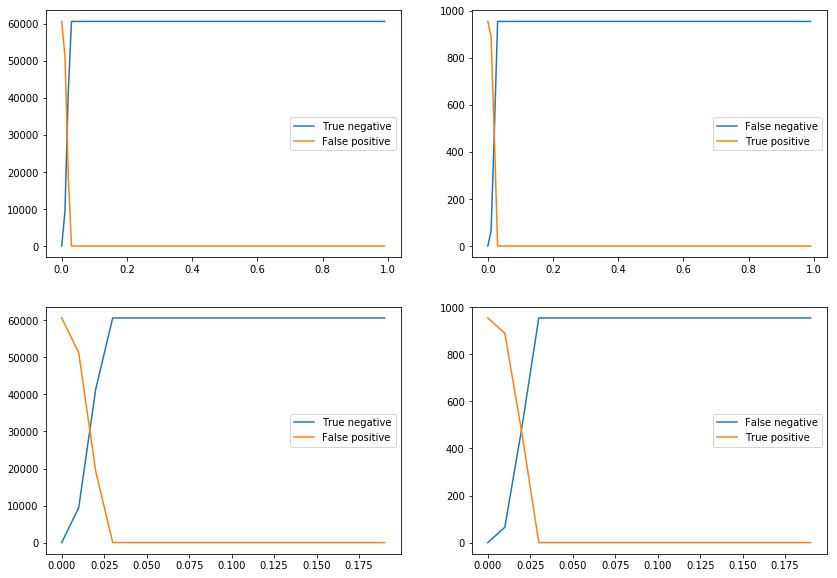

In [116]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

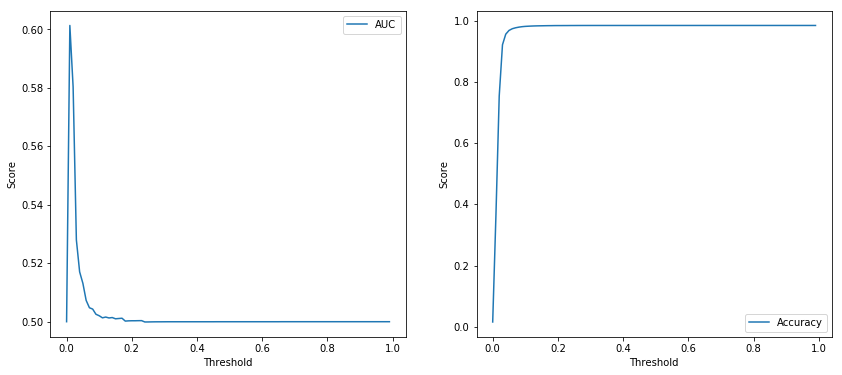

In [198]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

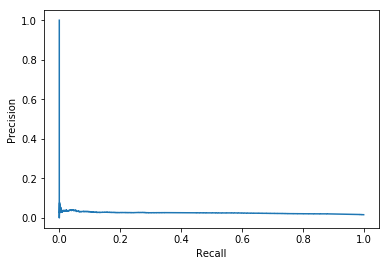

In [199]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Model 5 - With label encoding | excluding weather variables, neighborhood, address type and junction type

In [148]:
df = pd.read_csv('df_binary.csv')

In [149]:
df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Address Type','Junction Type'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Weather,Road Condition,Light Condition,Month,Date,Hour,Speed,Road Congestion,Road Length,Day of the Week
0,Not Severe,Raining,Wet,Daylight,12,12,15,48.0,2.36674,0.56104,Wednesday
1,Not Severe,Raining,Wet,Dark - Street Lights On,12,16,2,85.0,-1.00000,0.36276,Sunday
2,Not Severe,Overcast,Dry,Daylight,12,17,13,13.0,-1.00000,0.36276,Monday
3,Not Severe,Raining,Wet,Dark - Street Lights On,12,20,2,58.0,0.00000,1.73291,Thursday
4,Not Severe,Clear or Partly Cloudy,Dry,Dark - Street Lights On,12,14,17,55.0,1.57819,0.74738,Friday


In [150]:
le = LabelEncoder()
#df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
#df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

df_binary_base_model.head()

,Severity Description,Month,Date,Hour,Speed,Road Congestion,Road Length,Day of the Week
0,0,3,12,7,48.0,2.36674,0.56104,6
1,0,3,16,12,85.0,-1.00000,0.36276,3
2,0,3,17,5,13.0,-1.00000,0.36276,1
3,0,3,20,12,58.0,0.00000,1.73291,4
4,0,3,14,9,55.0,1.57819,0.74738,0


In [151]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204783, 7)
(204783,)


In [152]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

(143348, 7)
(61435, 7)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [153]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [154]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9842760641328233
0.9842760641328233
0.9842760641328233
0.9842760641328233


0    61434
1        1
dtype: int64

In [54]:
print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435



In [115]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60467 1 967 0


In [155]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.500517063081696


Combined ROC AUC=0.501
Severe class ROC AUC=0.588
Not severe class ROC AUC=0.412


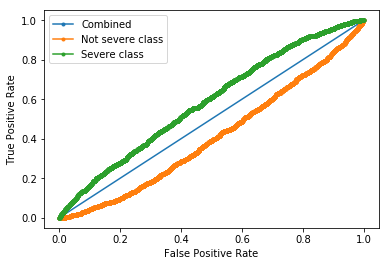

In [156]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [157]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

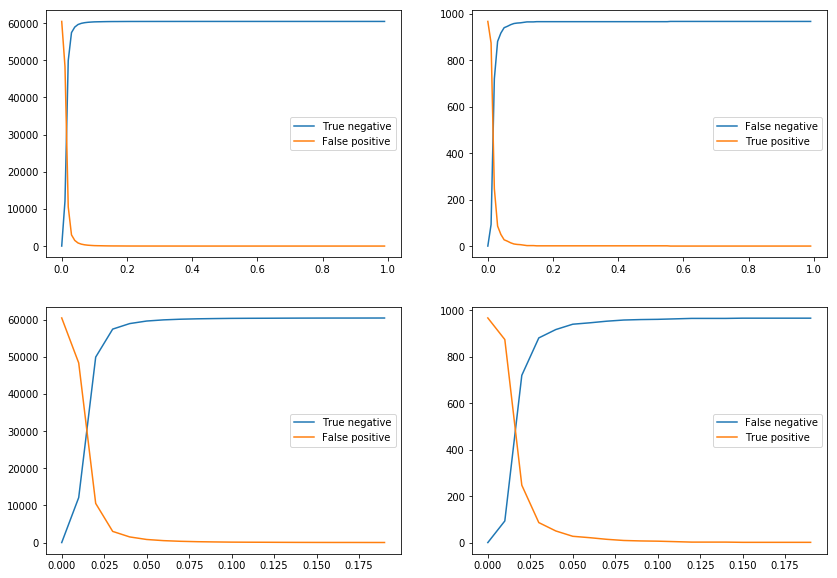

In [158]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

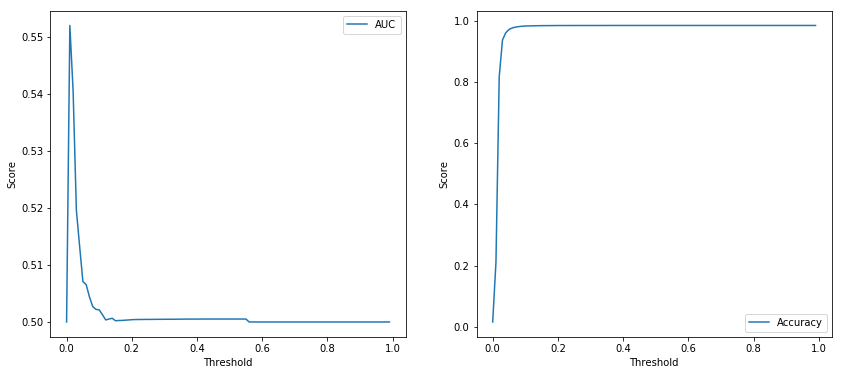

In [159]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

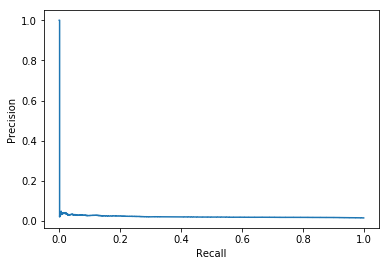

In [160]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

           Feature  Importance
3            Speed         538
1             Date         522
5      Road Length         491
4  Road Congestion         454
2             Hour         382
0            Month         339
6  Day of the Week         274


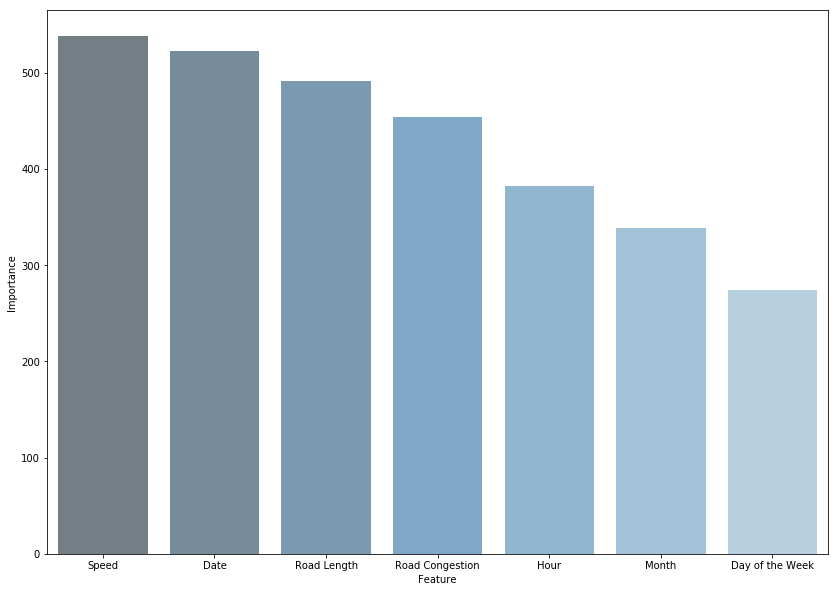

In [161]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

### Model 6 - With label encoding | only Speed, Road Length, Date, Hour, Road Congestion

In [162]:
df = pd.read_csv('df_binary.csv')

In [166]:
df_binary_base_model = df[['Severity Description','Speed','Road Length','Date','Hour','Road Congestion']]
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Congestion']<900]
df_binary_base_model = df_binary_base_model.dropna()
df_binary_base_model.head()

,Severity Description,Speed,Road Length,Date,Hour,Road Congestion
0,Not Severe,48.0,0.56104,12,15,2.36674
1,Not Severe,85.0,0.36276,16,2,-1.00000
2,Not Severe,13.0,0.36276,17,13,-1.00000
3,Not Severe,58.0,1.73291,20,2,0.00000
4,Not Severe,55.0,0.74738,14,17,1.57819


In [167]:
le = LabelEncoder()
#df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
#df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
#df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
#df_binary_base_model['Neighborhood'] = le.fit_transform(df_binary_base_model['Neighborhood'])
#df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))

df_binary_base_model.head()

,Severity Description,Speed,Road Length,Date,Hour,Road Congestion
0,0,48.0,0.56104,12,7,2.36674
1,0,85.0,0.36276,16,12,-1.00000
2,0,13.0,0.36276,17,5,-1.00000
3,0,58.0,1.73291,20,12,0.00000
4,0,55.0,0.74738,14,9,1.57819


In [168]:
X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

(204783, 5)
(204783,)


In [169]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

(143348, 5)
(61435, 5)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [170]:
#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lgb = LGBMClassifier()
model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

In [171]:
acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012


0    61435
dtype: int64

In [54]:
print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))

              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435



In [115]:
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

60467 1 967 0


In [172]:
#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

0.5


Combined ROC AUC=0.500
Severe class ROC AUC=0.581
Not severe class ROC AUC=0.419


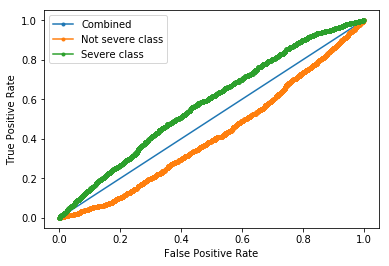

In [173]:
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

In [174]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
error_rate = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    error_rate.append((fp+fn)/(tp+fp+tn+fn))
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

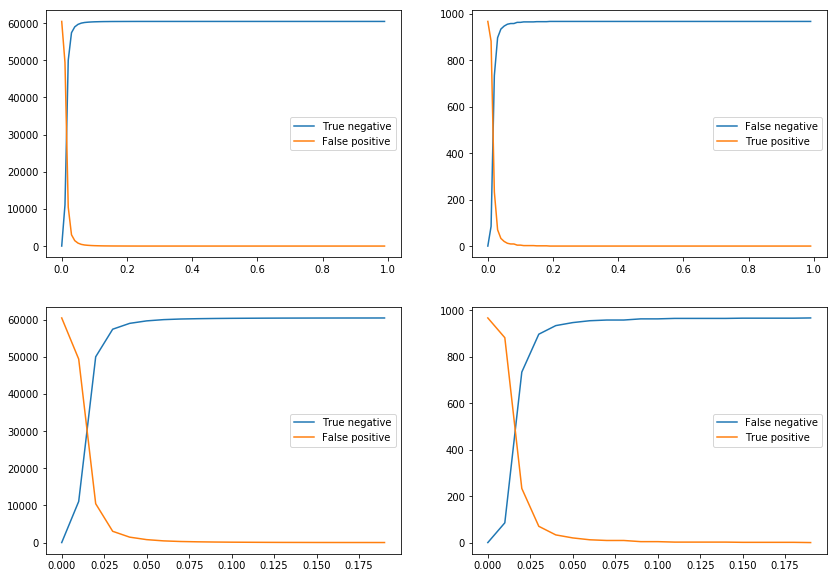

In [175]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [193]:
recall[:4]

array([1.        , 0.99896587, 0.99896587, 0.99896587])

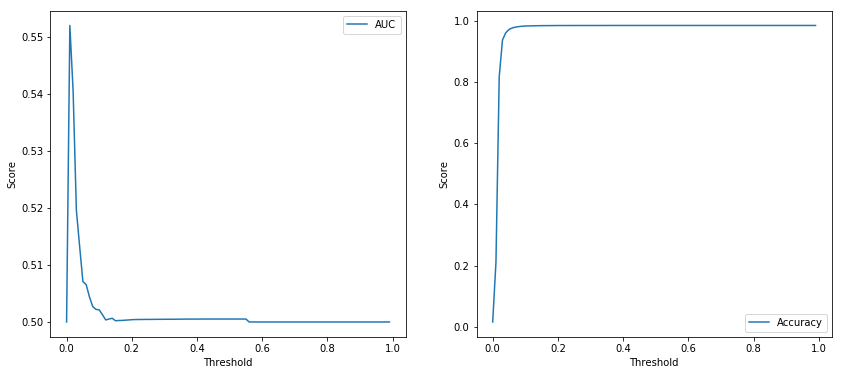

In [159]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

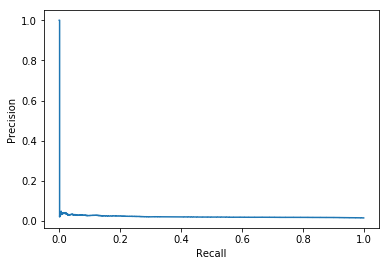

In [160]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

           Feature  Importance
0            Speed         674
2             Date         661
4  Road Congestion         583
1      Road Length         575
3             Hour         507


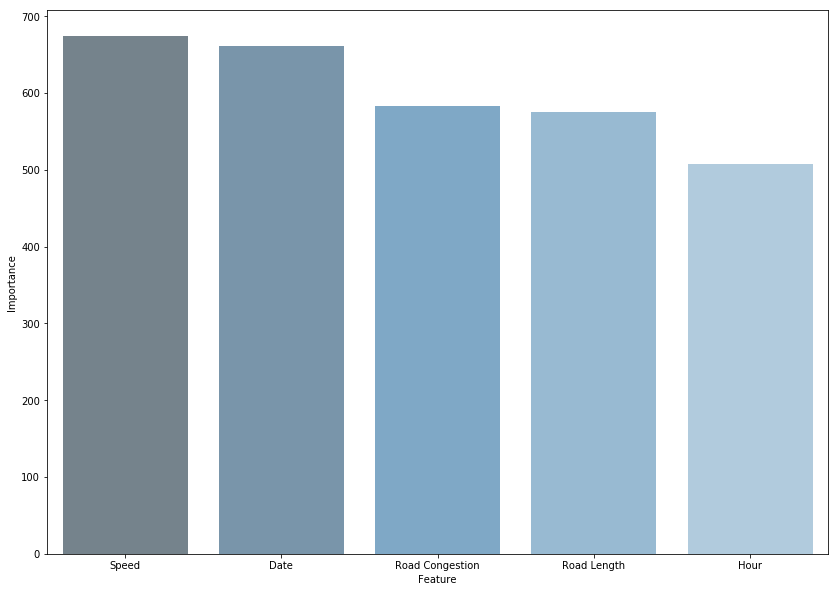

In [176]:
model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

### Model 8 - Logistic Regression | With label encoding | excluding weather variables and neighborhood

(204783, 8)
(204783,)
(143348, 8)
(61435, 8)
(143348,)
(61435,)
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.9842597867665012
Precision:  0.9842597867665012
Recall:  0.9842597867665012
F1 score:  0.9842597867665012
Combined AUC score:  0.5

Distribution of severity classes in y_test sample
0    60468
1      967
Name: Severity Description, dtype: int64

Distribution of severity class in predicted sample
0    61435
dtype: int64
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0
0.5


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.629
Not severe class ROC AUC=0.371


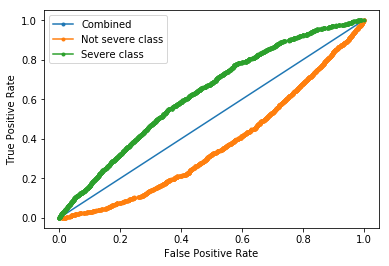

In [66]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_train.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

lr = LogisticRegression(C=1)
model = lr.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print ("Accuracy: ",acc)
prc = precision_score(y_test,prediction,average='micro')
print ("Precision: ",prc)
rec = recall_score(y_test,prediction,average='micro')
print ("Recall: ",rec)
f1 = f1_score(y_test,prediction,average='micro')
print ("F1 score: ",f1)
auc = roc_auc_score(y_test,prediction)
print ("Combined AUC score: ",auc)
print ()
print ("Distribution of severity classes in y_test sample")
print (pd.Series(y_test).value_counts())
print ()
print ("Distribution of severity class in predicted sample")
print (pd.Series(prediction).value_counts())

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

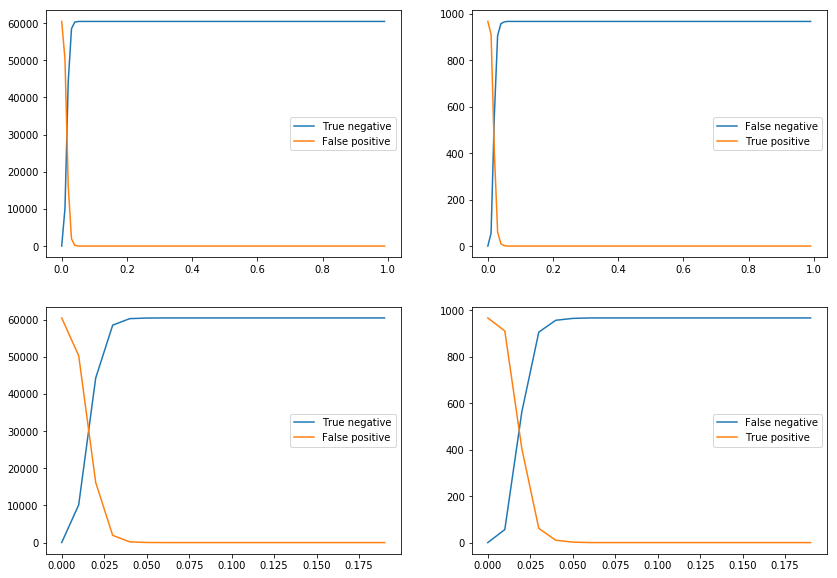

In [67]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

### Logistic Regression with SMOTE

(204783, 8)
(204783,)
(143348, 8)
(61435, 8)
(143348,)
(61435,)
[(0, 141086), (1, 141358)]
   Values    Percent
0  141086  98.422022
1    2262   1.577978
   Values    Percent
0   60468  98.425979
1     967   1.574021


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:  0.6130707251566696
Precision:  0.6130707251566696
Recall:  0.6130707251566696
F1 score:  0.6130707251566696
Combined AUC score:  0.5953446433913372

Distribution of severity classes in y_test sample
0    60468
1      967
Name: Severity Description, dtype: int64

Distribution of severity class in predicted sample
0    37515
1    23920
dtype: int64
              precision    recall  f1-score   support

  Not Severe       0.99      0.61      0.76     60468
      Severe       0.02      0.58      0.04       967

    accuracy                           0.61     61435
   macro avg       0.51      0.60      0.40     61435
weighted avg       0.97      0.61      0.75     61435

37106 23362 409 558
0.5953446433913372
Combined ROC AUC=0.595
Severe class ROC AUC=0.629
Not severe class ROC AUC=0.371


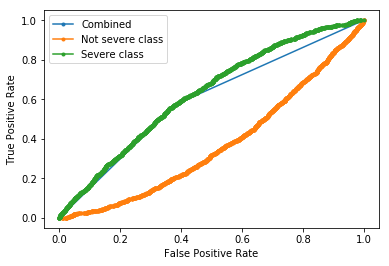

In [56]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

y_train_cat = pd.DataFrame()
y_train_cat['Values'] = y_resampled.value_counts()
y_train_cat['Percent'] = (y_train_cat['Values']/sum(y_train_cat['Values']))*100
y_test_cat = pd.DataFrame()
y_test_cat['Values'] = y_test.value_counts()
y_test_cat['Percent'] = (y_test_cat['Values']/sum(y_test_cat['Values']))*100
print (y_train_cat)
print (y_test_cat)

#train_data=lgb.Dataset(x_train,label=y_train)
#param = {'objective':'binary','max_depth':7,'learning_rate':.05}
#num_rounds = 10
#lgbm = lgb.train(param,train_data,num_rounds)
lr = LogisticRegression(C=1)
model = lr.fit(x_resampled,y_resampled)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print ("Accuracy: ",acc)
prc = precision_score(y_test,prediction,average='micro')
print ("Precision: ",prc)
rec = recall_score(y_test,prediction,average='micro')
print ("Recall: ",rec)
f1 = f1_score(y_test,prediction,average='micro')
print ("F1 score: ",f1)
auc = roc_auc_score(y_test,prediction)
print ("Combined AUC score: ",auc)
print ()
print ("Distribution of severity classes in y_test sample")
print (pd.Series(y_test).value_counts())
print ()
print ("Distribution of severity class in predicted sample")
print (pd.Series(prediction).value_counts())

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

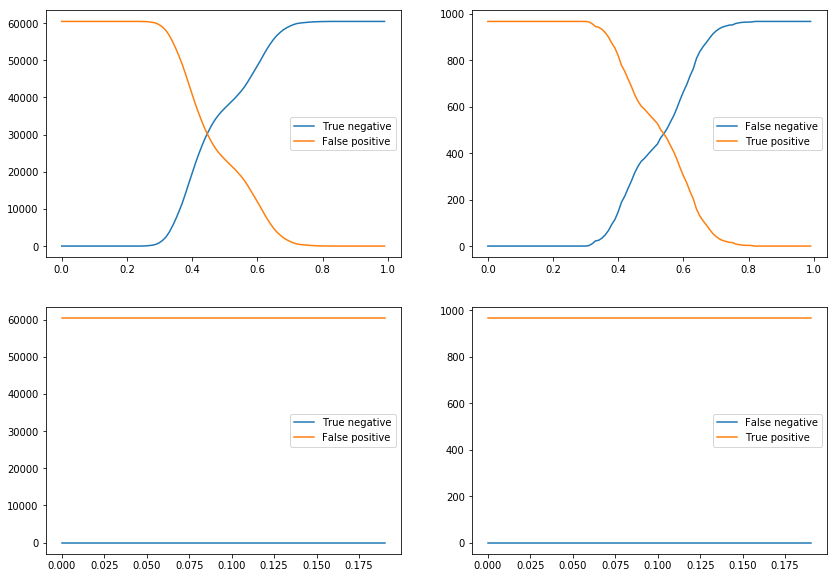

In [57]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

In [34]:
x_resampled, y_resampled = ADASYN().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 141086), (1, 141453)]


In [39]:
df_auc = pd.DataFrame()
df_auc['tpr'] = lr_tpr_pos
df_auc['fpr'] = lr_fpr_pos
df_auc['thresh'] = thresh
print (len(thresh))
print (df_auc.head(40))

df_prob = pd.DataFrame()
lr_probs = model.predict_proba(x_test)
df_prob['Non severe'] = lr_probs[:, 0]
df_prob['Severe'] = lr_probs[:, 1]
print (df_prob.head(20))
print (len(thresh))
print (len(lr_probs[:, 0]))
print (df_prob.describe())

12541
         tpr       fpr    thresh
0   0.000000  0.000000  1.659394
1   0.000000  0.000017  0.659394
2   0.000000  0.000132  0.251916
3   0.000000  0.000165  0.250157
4   0.000000  0.000198  0.239098
5   0.001034  0.000198  0.237842
6   0.001034  0.000645  0.177155
7   0.002068  0.000645  0.176962
8   0.002068  0.000728  0.172566
9   0.003102  0.000728  0.171861
10  0.003102  0.000777  0.168367
11  0.003102  0.000810  0.166855
12  0.003102  0.001141  0.149496
13  0.004137  0.001141  0.146856
14  0.004137  0.001406  0.135480
15  0.004137  0.001439  0.134646
16  0.004137  0.001571  0.130169
17  0.005171  0.001571  0.129763
18  0.005171  0.002216  0.114465
19  0.005171  0.002249  0.114437
20  0.005171  0.002844  0.105338
21  0.006205  0.002844  0.104950
22  0.006205  0.002977  0.102469
23  0.007239  0.002977  0.102438
24  0.007239  0.003225  0.099286
25  0.008273  0.003225  0.099256
26  0.008273  0.003986  0.091828
27  0.008273  0.004019  0.091696
28  0.008273  0.004118  0.091049
29  

#### Changing thresholds

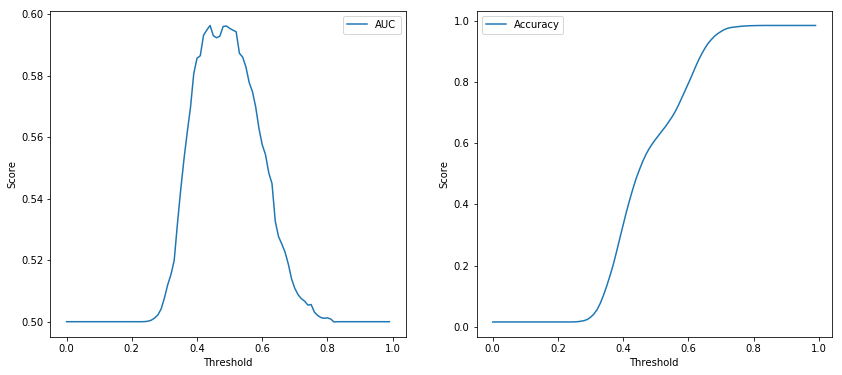

In [58]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

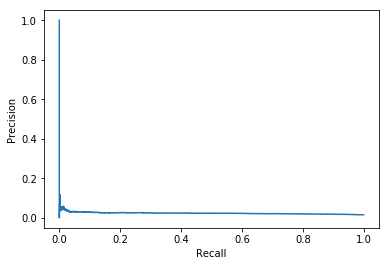

In [59]:
# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [62]:
#model.n_features_
#model.best_score_
#model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

### Model 9 - Random Forest

(204783, 8)
(204783,)
(143348, 8)
(61435, 8)
(143348,)
(61435,)
[(0, 141086), (1, 141086)]


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9832668674208513
0.9832668674208513
0.9832668674208513
0.9832668674208513
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.04      0.00      0.01       967

    accuracy                           0.98     61435
   macro avg       0.51      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60404 64 964 3
0.50102198371489
Combined ROC AUC=0.501
Severe class ROC AUC=0.547
Not severe class ROC AUC=0.453


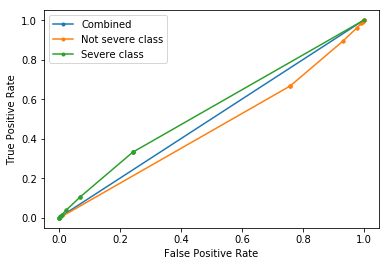

In [175]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

rf = RandomForestClassifier()
model = rf.fit(x_resampled,y_resampled)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

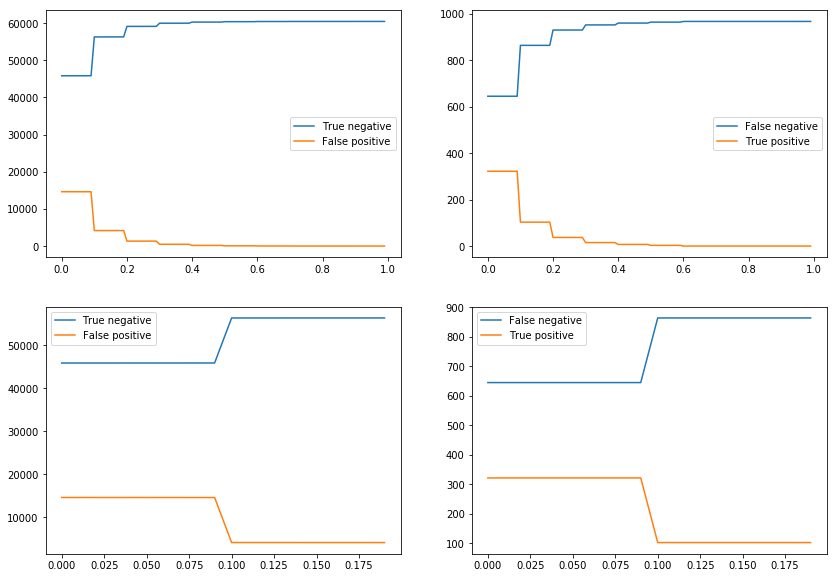

In [176]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

### Grid Search - LightGBM

In [37]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

(204783, 8)
(204783,)


In [69]:
from sklearn.model_selection import GridSearchCV
#pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

params = {'max_depth' : [5,10],
    'num_leaves':[10,30,50],
         'learning_rate':[0.001,0.003,0.005,0.01],
         'min_data_in_leaf':[1000,2000,5000,10000,50000],
         'objective':['binary'],
         }

# Create grid search object
lgb = LGBMClassifier()
clf = GridSearchCV(lgb, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


In [70]:
print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
clf.cv_results_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=1000, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=30, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
0.6397568831048397
{'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 1000, 'num_leaves': 30, 'objective': 'binary'}


{'mean_fit_time': array([0.74279494, 0.86531172, 0.86795535, 0.75243783, 0.89106088,
        0.87741251, 0.78903737, 0.85767875, 0.85607781, 0.77297115,
        0.73697615, 0.73035007, 0.48356581, 0.48331614, 0.48117104,
        0.74591851, 0.85793467, 0.8537374 , 0.75686135, 0.88622313,
        0.87951307, 0.78819218, 0.85841022, 0.85121613, 0.7249547 ,
        0.73372698, 0.7304656 , 0.47972789, 0.48227644, 0.48071618,
        0.74792295, 0.85375366, 0.85530066, 0.75806966, 0.87342253,
        0.87470188, 1.2032176 , 0.84759264, 0.84877915, 0.73278875,
        0.73569345, 0.73232217, 0.48174376, 0.48183188, 0.48266125,
        0.74409947, 0.84702802, 0.85089889, 0.76166644, 0.86445866,
        0.86097007, 0.77980957, 0.85107756, 0.84802885, 0.73687582,
        0.73402853, 0.73214736, 0.4843256 , 0.48015265, 0.48226581]),
 'std_fit_time': array([0.01662964, 0.01605373, 0.013989  , 0.00717378, 0.02176541,
        0.01873385, 0.01170945, 0.03126962, 0.02750451, 0.06082084,
        0.036

### Applying tuned hyperparameters to LightGBM model

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.659
Not severe class ROC AUC=0.341


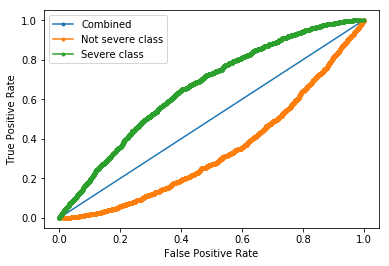

In [72]:
lgb = LGBMClassifier(num_leaves=50, max_depth=5,objective='binary')

model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

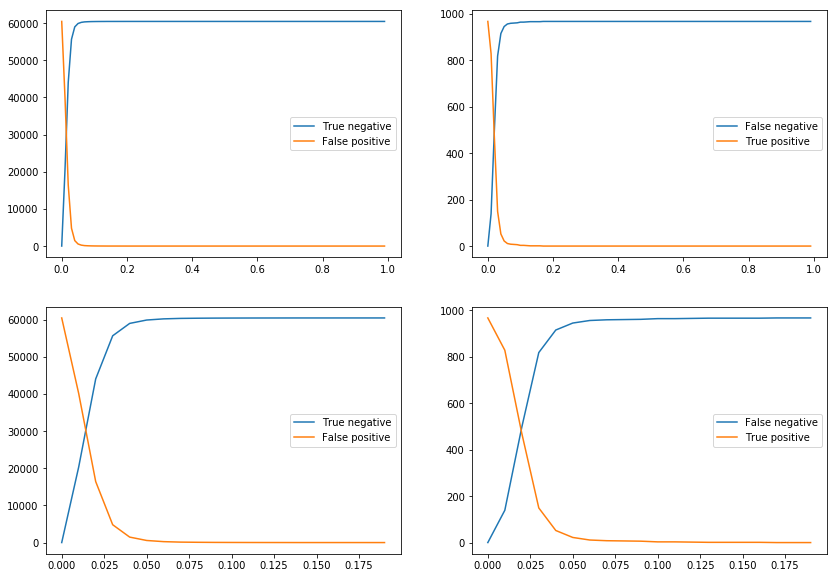

In [73]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))
    
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative')
plt.plot(threshold,confusion['fp'],label='False positive')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative')
plt.plot(threshold,confusion['tp'],label='True positive')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative')
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative')
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive')
plt.legend()
plt.show()

### Applying tuned hyperparameters to LightGBM model with feature scaling

In [3]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
x_cols = x_train.columns

(204783, 8)
(204783,)


In [4]:
# Normalizing continuous variables

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

TN:  60468
FP:  0
FN:  967
TP:  0


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.660
Not severe class ROC AUC=0.340


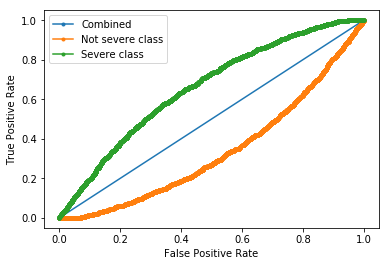

In [5]:
lgb = LGBMClassifier(min_data_in_leaf=20,learning_rate=0.1,num_leaves=10, max_depth=5,objective='binary')
#lgb = LGBMClassifier(num_leaves=10, max_depth=5,objective='binary')

model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print ("TN: ",tn)
print ("FP: ",fp)
print ("FN: ",fn)
print ("TP: ",tp)

#AUC
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

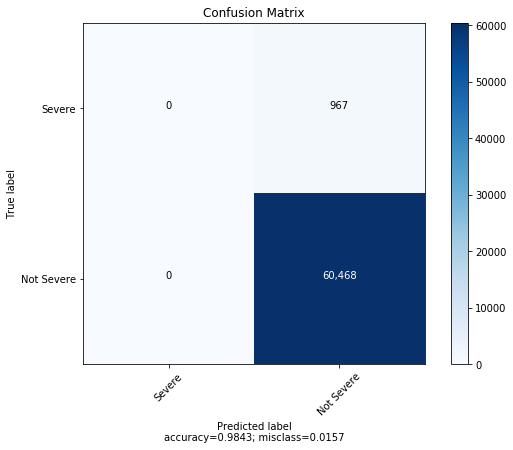

In [180]:
plot_confusion_matrix(cm           = np.array([[ tp,  fn],
                                              [  fp, tn]]), 
                      normalize    = False,
                      target_names = ['Severe', 'Not Severe'],
                      title        = "Confusion Matrix")

In [6]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
error_rate = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    error_rate.append((fp+fn)/(tp+fp+tn+fn))
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

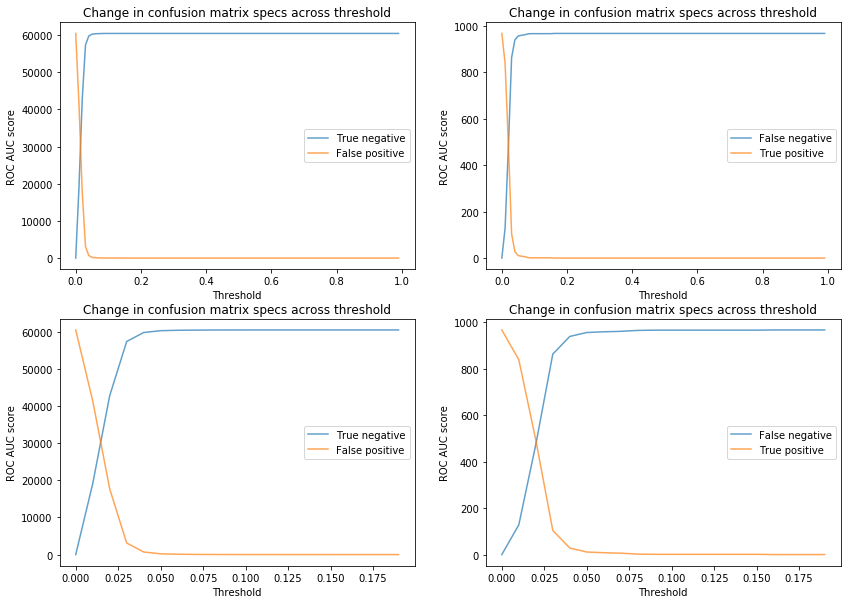

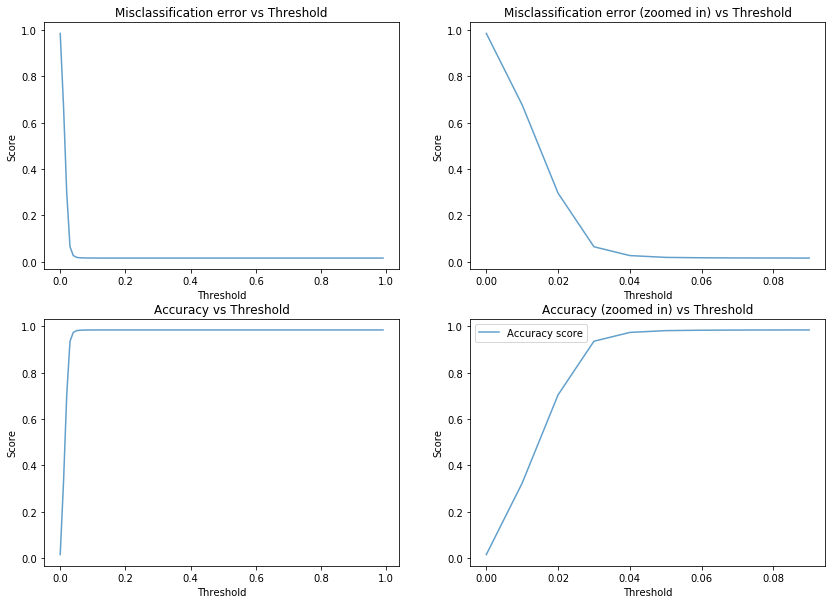

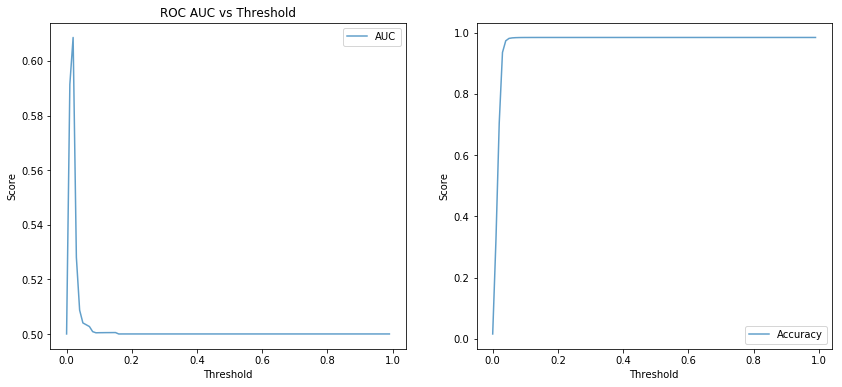

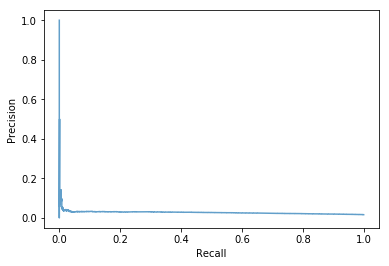

           Feature  Importance
6      Road Length         193
5            Speed         184
4             Hour         151
2            Month          96
3             Date          96
1    Junction Type          89
7  Day of the Week          64
0     Address Type          27


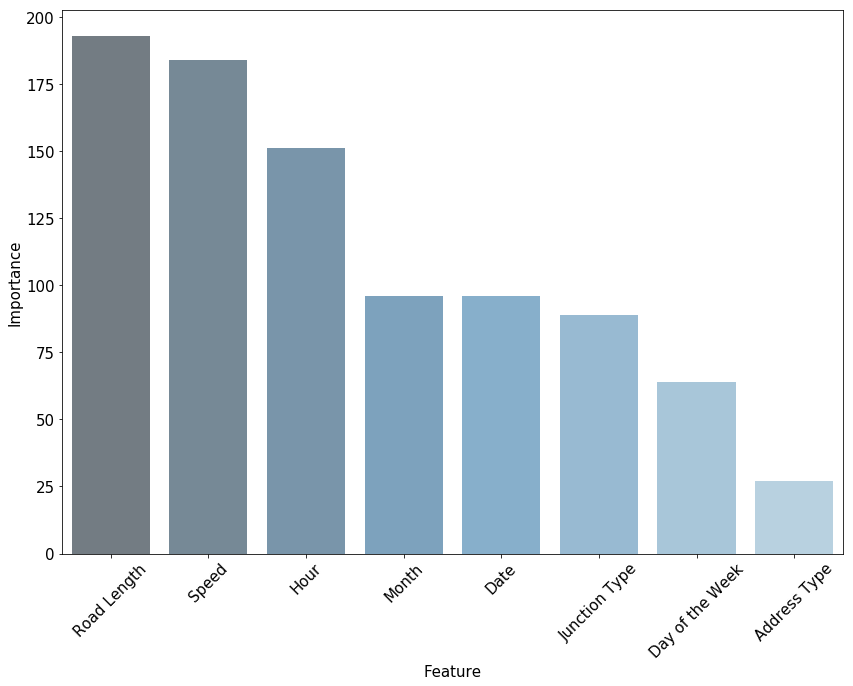

In [8]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative',alpha=0.7)
plt.plot(threshold,confusion['fp'],label='False positive',alpha=0.7)
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative',alpha=0.7)
plt.plot(threshold,confusion['tp'],label='True positive',alpha=0.7)
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[:20],confusion['tn'][:20],label='True negative',alpha=0.7)
plt.plot(threshold[:20],confusion['fp'][:20],label='False positive',alpha=0.7)
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[:20],confusion['fn'][:20],label='False negative',alpha=0.7)
plt.plot(threshold[:20],confusion['tp'][:20],label='True positive',alpha=0.7)
plt.title('Change in confusion matrix specs across threshold')
plt.xlabel('Threshold')
plt.ylabel('ROC AUC score')
plt.legend()
plt.show()

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,error_rate,label='Misclassification error',alpha=0.7)
plt.title('Misclassification error vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.subplot(2,2,2)
plt.plot(threshold[:10],error_rate[:10],label='Misclassification error',alpha=0.7)
plt.title('Misclassification error (zoomed in) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.subplot(2,2,3)
plt.plot(threshold,acc,label='Accuracy',alpha=0.7)
plt.title('Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.subplot(2,2,4)
plt.plot(threshold[:10],acc[:10],label='Accuracy score',alpha=0.7)
plt.title('Accuracy (zoomed in) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC',alpha=0.7)
plt.title('ROC AUC vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy',alpha=0.7)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision,alpha=0.7)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

features = pd.DataFrame()
features['Feature'] = x_cols
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.xticks(size=15,rotation=45)
plt.yticks(size=15)
plt.xlabel('Feature',size=15)
plt.ylabel('Importance',size=15)
plt.show()

### Finding optimum regularization point

In [245]:
lr_auc_pos_test = []
lr_auc_neg_test = []
lr_auc_pos_train = []
lr_auc_neg_train = []

for i in range(11):
    for j in range(10,110,10):
        #lgb = LGBMClassifier(min_data_in_leaf=20,learning_rate=0.1,num_leaves=int(i),max_depth=5,objective='binary')
        lgb = LGBMClassifier(min_data_in_leaf=20,learning_rate=0.1,num_leaves=int(j),max_depth=int(i),objective='binary')
        model = lgb.fit(x_train,y_train)

        #AUC
        lr_probs_test = model.predict_proba(x_test)
        lr_probs_train = model.predict_proba(x_train)

        # keep probabilities for the positive outcome only
        lr_probs_pos_test = lr_probs_test[:,1]
        lr_probs_neg_test = lr_probs_test[:,0]
        lr_probs_pos_train = lr_probs_train[:,1]
        lr_probs_neg_train = lr_probs_train[:,0]

        # calculate scores
        #lr_auc_test = roc_auc_score(y_test, prediction)
        lr_auc_pos_test.append(roc_auc_score(y_test, lr_probs_pos_test))
        lr_auc_neg_test.append(roc_auc_score(y_test, lr_probs_neg_test))
        #lr_auc_train = roc_auc_score(y_test, prediction)
        lr_auc_pos_train.append(roc_auc_score(y_train, lr_probs_pos_train))
        lr_auc_neg_train.append(roc_auc_score(y_train, lr_probs_neg_train))

'''
# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
'''

"\n# summarize scores\nprint('Combined ROC AUC=%.3f' % (lr_auc))\nprint('Severe class ROC AUC=%.3f' % (lr_auc_pos))\nprint('Not severe class ROC AUC=%.3f' % (lr_auc_neg))\n\nlr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)\nlr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])\nlr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)\n# plot the roc curve for the model\nplt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')\nplt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')\nplt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')\n# axis labels\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\n# show the legend\nplt.legend()\n# show the plot\nplt.show()\n"

### Number of leaves sweep

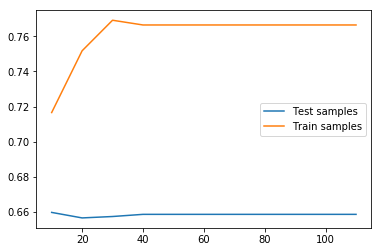

In [239]:
plt.plot([10,20,30,40,50,60,70,80,90,100,110],lr_auc_pos_test,label='Test samples')
plt.plot([10,20,30,40,50,60,70,80,90,100,110],lr_auc_pos_train,label='Train samples')
plt.xlabel('Iterations')
plt.ylabel('ROC AUC score')
plt.legend()

### Max depth sweep

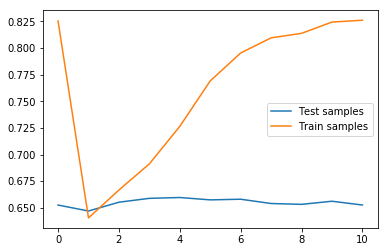

In [241]:
plt.plot(range(11),lr_auc_pos_test,label='Test samples')
plt.plot(range(11),lr_auc_pos_train,label='Train samples')
plt.xlabel('Iterations')
plt.ylabel('ROC AUC score')
plt.legend()

### Number of leaves and max depth sweep

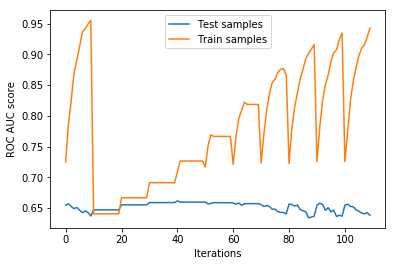

In [249]:
plt.plot(lr_auc_pos_test,label='Test samples')
plt.plot(lr_auc_pos_train,label='Train samples')
plt.xlabel('Iterations')
plt.ylabel('ROC AUC score')
#plt.title("ROC AUC scores for train and test samples across number of leaves and max depth")
plt.legend()

The plot above shows the ROC AUC scores when the trained model is tested against both train and test samples by sweeping the *number of leaves* and *max depth* hyperparameters. 

Since the number of leaves is the outer loop, the points at 0, 10, 20 and so on represent different number of leaves while the points between 0-10, 10-20 and so on represent different max depth values. 

From the plot, we can observe that the test sample performance remains fairly flat as compared to the train sample performance. Hence, higher train sample performance means greater over-fitting. Based on this, the points between 10-20 offers the best model in terms of dealing with overfitting. From point 20, each increase in test samples performance increases train samples performance by a higher rate. Therefore, the ideal points are between 10-40. Anything above that would make the model overfit more and more. 

In [257]:
predictions = (lr_probs[:,1]>0.02).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
error_rate = (fp+fn)/(tp+fp+tn+fn)
print (accuracy_score(y_test,predictions))
print (precision_score(y_test,predictions))
print (error_rate)
print (tn,fp,fn,tp)

0.7042239765605925
0.027102803738317756
0.2957760234394075
42771 17697 474 493


### Grid Search - logistic regression

In [80]:
df = pd.read_csv('df_binary.csv')

df_binary_base_model = df.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_binary_base_model = df_binary_base_model[df_binary_base_model['Road Length']<900]
df_binary_base_model = df_binary_base_model.dropna()

le = LabelEncoder()
df_binary_base_model['Address Type'] = le.fit_transform(df_binary_base_model['Address Type'])
df_binary_base_model['Junction Type'] = le.fit_transform(df_binary_base_model['Junction Type'])
df_binary_base_model['Month'] = le.fit_transform(df_binary_base_model['Month'].map(str))
df_binary_base_model['Hour'] = le.fit_transform(df_binary_base_model['Hour'].map(str))
df_binary_base_model['Day of the Week'] = le.fit_transform(df_binary_base_model['Day of the Week'])
df_binary_base_model['Severity Description'] = le.fit_transform(df_binary_base_model['Severity Description'].map(str))
df_binary_base_model = df_binary_base_model.drop(['Weather','Light Condition','Road Condition'],axis=1)

X = df_binary_base_model.drop('Severity Description',axis=1)
Y = df_binary_base_model['Severity Description']
print (X.shape)
print (Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

(204783, 8)
(204783,)
[(0, 141086), (1, 141086)]


In [83]:
from sklearn.model_selection import GridSearchCV
#pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

params = {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}

# Create grid search object
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_resampled, y_resampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.0min finished


In [85]:
print (clf.best_estimator_)
print (clf.best_score_)
print (clf.best_params_)
clf.cv_results_

LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
0.6337315580594873
{'C': 10000.0, 'penalty': 'l2', 'solver': 'liblinear'}


{'mean_fit_time': array([0.54122128, 0.45367441, 0.59403987, 0.56159172, 0.92113328,
        0.54431829, 1.15068007, 0.71419845, 2.32134733, 0.70907779,
        3.26220269, 0.79668546, 3.02322507, 0.8120491 , 3.49185185,
        0.83281007, 3.3871305 , 0.85782652, 3.28404393, 0.85289378,
        3.39263082, 0.85680985, 3.06964836, 0.84624348, 3.50859132,
        0.84702244, 3.46405859, 0.84182644, 3.5199976 , 0.82416801,
        3.54660783, 0.7835876 , 3.42203751, 0.85124049, 3.37232151,
        0.85825982, 3.36846461, 0.84253573, 3.2832324 , 0.82315955]),
 'std_fit_time': array([0.04669798, 0.00742839, 0.04518759, 0.05059866, 0.0246122 ,
        0.00333495, 0.08984044, 0.00722984, 0.48224598, 0.03659309,
        0.39203945, 0.03949465, 0.38893076, 0.04001186, 0.22145268,
        0.03292738, 0.14628692, 0.00905105, 0.24091825, 0.01198008,
        0.07258071, 0.00838541, 0.2055889 , 0.00976057, 0.18022831,
        0.00797599, 0.23146005, 0.05322821, 0.30685472, 0.03991938,
        0.476

### Applying optimized hyperparameters to logistic regression model with SMOTE

0.6141938634328965
0.6141938634328965
0.6141938634328965
0.6141938634328965
              precision    recall  f1-score   support

  Not Severe       0.99      0.61      0.76     60468
      Severe       0.02      0.58      0.05       967

    accuracy                           0.61     61435
   macro avg       0.51      0.60      0.40     61435
weighted avg       0.97      0.61      0.75     61435

37174 23294 408 559
0.5964239873488684
Combined ROC AUC=0.596
Severe class ROC AUC=0.628
Not severe class ROC AUC=0.372


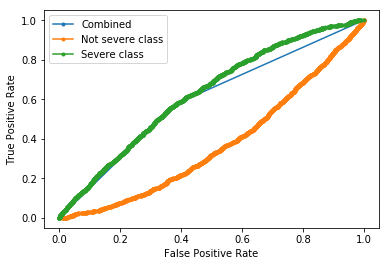

In [89]:
lr = LogisticRegression(C=10000,penalty='l2',solver='liblinear')
model = lr.fit(x_resampled,y_resampled)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Applying optimized hyperparameters to logistic regression model

0.9842597867665012
0.9842597867665012
0.9842597867665012
0.9842597867665012
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     60468
      Severe       0.00      0.00      0.00       967

    accuracy                           0.98     61435
   macro avg       0.49      0.50      0.50     61435
weighted avg       0.97      0.98      0.98     61435

60468 0 967 0
0.5


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Combined ROC AUC=0.500
Severe class ROC AUC=0.629
Not severe class ROC AUC=0.371


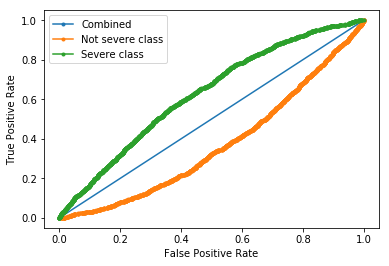

In [35]:
lr = LogisticRegression(C=1438.44988828766,penalty='l1',solver='liblinear')
model = lr.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
#y_test = le.fit_transform(y_test)
#prediction = le.fit_transform(prediction)
auc = roc_auc_score(y_test,prediction)
print (auc)

lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [90]:
confusion = {'tn':[],'fp':[],'fn':[],'tp':[]}
auc = [] 
acc = []
pre = []
rec = [] 
threshold = []
error_rate = []
ticks = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1']
for i in np.arange(0,1,0.01):
    threshold.append(i)
    # predict probabilities
    lr_probs = model.predict_proba(x_test)
    predictions = (lr_probs[:,1]>i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    error_rate.append((fp+fn)/(tp+fp+tn+fn))
    confusion['tn'].append(tn)
    confusion['fp'].append(fp)
    confusion['fn'].append(fn)
    confusion['tp'].append(tp)
    acc.append(accuracy_score(y_test,predictions))
    auc.append(roc_auc_score(y_test,predictions))
    #pre.append(precision_score(y_test,predictions))
    rec.append(recall_score(y_test,predictions))

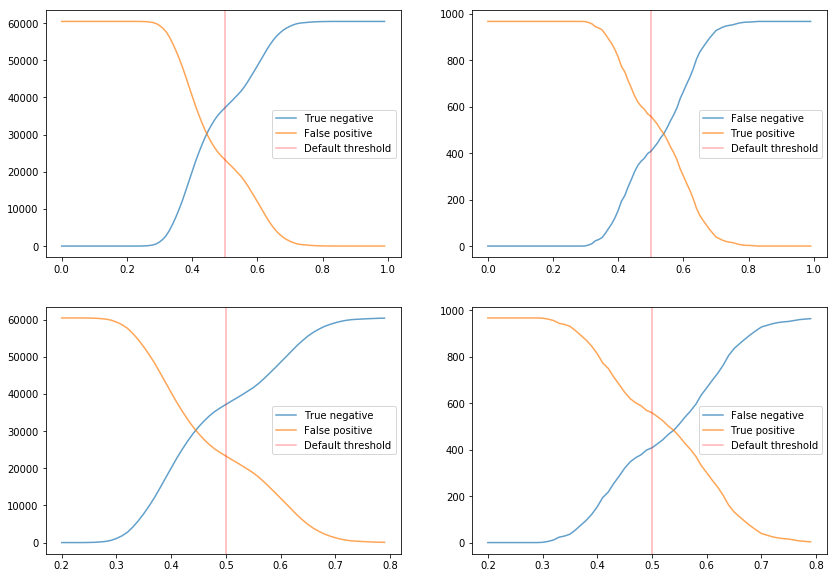

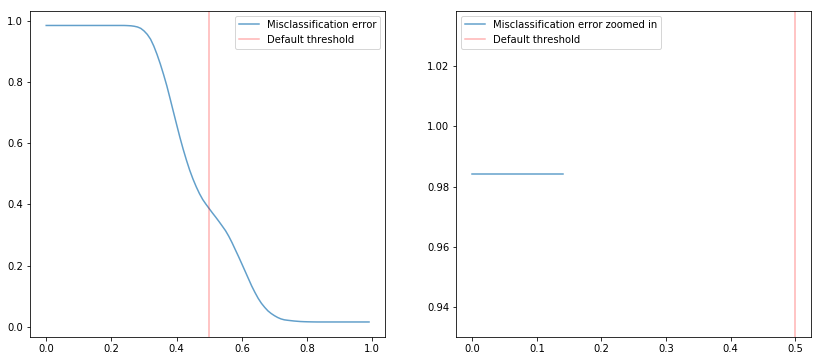

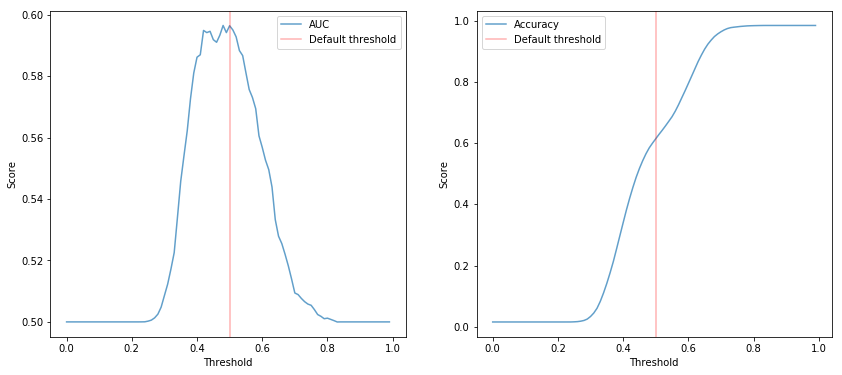

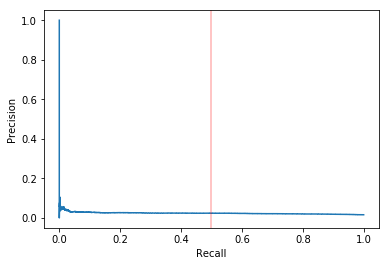

AttributeError: 'LogisticRegression' object has no attribute 'n_features_'

In [99]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(threshold,confusion['tn'],label='True negative',alpha=0.7)
plt.plot(threshold,confusion['fp'],label='False positive',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.legend()
plt.subplot(2,2,2)
plt.plot(threshold,confusion['fn'],label='False negative',alpha=0.7)
plt.plot(threshold,confusion['tp'],label='True positive',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.legend()
plt.subplot(2,2,3)
plt.plot(threshold[20:80],confusion['tn'][20:80],label='True negative',alpha=0.7)
plt.plot(threshold[20:80],confusion['fp'][20:80],label='False positive',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.legend()
plt.subplot(2,2,4)
plt.plot(threshold[20:80],confusion['fn'][20:80],label='False negative',alpha=0.7)
plt.plot(threshold[20:80],confusion['tp'][20:80],label='True positive',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,error_rate,label='Misclassification error',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold[:15],error_rate[:15],label='Misclassification error zoomed in',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.legend()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(threshold,auc,label='AUC',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(threshold,acc,label='Accuracy',alpha=0.7)
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# predict probabilities
lr_probs = model.predict_proba(x_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axvline(0.5,color='red',alpha=0.3,label='Default threshold')
plt.show()

model.n_features_
model.best_score_
model.booster_
features = pd.DataFrame()
features['Feature'] = x_train.columns
features['Importance'] = model.feature_importances_
print (features.sort_values('Importance',ascending=False))

plt.figure(figsize=(14,10))
sns.barplot(x='Feature',y='Importance',data=features.sort_values('Importance',ascending=False),alpha=0.7,palette='Blues_d')
plt.show()

## Splitting train and test data by time period

In [24]:
df_time = pd.read_csv('df_binary.csv')

#Assigning the index to the datetime variable and sorting the data by the index
df_time.index = df_time['Incident Date and Time']
df_time = df_time.sort_index()
df_time.head()

,Unnamed: 0,Longitude,Latitude,Status,Address Type,Severity Description,Collision Type,Number of People Involved,Number of Pedestrians Involved,Number of Bicycles Involved,...,Month,Date,Hour,Minute,Speed,Road Congestion,Road Length,Neighborhood,Num People Square,Day of the Week
Incident Date and Time,,,,,,,,,,,,,,,,,,,,,
2003-10-06 00:00:00,564,-122.320755,47.608073,Matched,Intersection,Not Severe,Unknown,0,0,0,...,10,6,0,0,21.0,-1.0000,0.23056,Seattle,0,Monday
2004-01-01 00:00:00,11945,-122.360959,47.571594,Unmatched,Block,Not Severe,Unknown,0,0,0,...,1,1,0,0,87.0,0.0000,0.61293,Seattle,0,Thursday
2004-01-01 00:00:00,12434,-122.321877,47.605770,Matched,Intersection,Severe,Angles,4,0,0,...,1,1,0,0,27.0,-1.0000,0.23056,Seattle,16,Thursday
2004-01-01 00:00:00,9971,-122.350466,47.613367,Matched,Intersection,Not Severe,Angles,2,0,0,...,1,1,0,0,35.0,3.8431,0.34420,Seattle,4,Thursday
2004-01-01 00:00:00,17351,-122.321448,47.614071,Matched,Block,Not Severe,Sideswipe,5,0,0,...,1,1,0,0,16.0,-1.0000,0.43432,Seattle,25,Thursday


In [25]:
df_time = df_time.drop(['Latitude','Longitude','Status','Number of People Involved',
                            'Number of Pedestrians Involved','Number of Vehicles Involved',
                           'Number of Bicycles Involved','Number of Injuries','Number of Serious Injuries',
                           'Number of Fatalities','Incident Date and Time','DUI','SDOT Collision Description',
                           'STATE Collision Description','Hit Parked Car','Year',
                           'Minute','Collision Type','Unnamed: 0','Num People Square','Neighborhood','Road Congestion'],axis=1)
df_time = df_time[df_time['Road Length']<900]
df_time = df_time.dropna()

le = LabelEncoder()
df_time['Address Type'] = le.fit_transform(df_time['Address Type'])
df_time['Junction Type'] = le.fit_transform(df_time['Junction Type'])
df_time['Month'] = le.fit_transform(df_time['Month'].map(str))
df_time['Hour'] = le.fit_transform(df_time['Hour'].map(str))
df_time['Day of the Week'] = le.fit_transform(df_time['Day of the Week'])
df_time['Severity Description'] = le.fit_transform(df_time['Severity Description'].map(str))
df_time = df_time.drop(['Weather','Light Condition','Road Condition'],axis=1)

In [26]:
#Splitting the data manually by year
train = df_time[:'2017']
test = df_time['2017':]
print (train.shape)
print (test.shape)
df_time.shape

(173922, 9)
(30861, 9)


(204783, 9)

In [56]:
train_df = pd.DataFrame()
train_df['Count'] = train.groupby('Severity Description')['Month'].count()
train_df['Rate'] = train_df['Count'].apply(lambda x: (x/sum(train_df['Count']))*100)

test_df = pd.DataFrame()
test_df['Count'] = test.groupby('Severity Description')['Month'].count()
test_df['Rate'] = test_df['Count'].apply(lambda x: (x/sum(test_df['Count']))*100)
print (train_df)
print (test_df)

                       Count       Rate
Severity Description                   
0                     171203  98.436656
1                       2719   1.563344
                      Count       Rate
Severity Description                  
0                     30351  98.347429
1                       510   1.652571


Above we confirm that the event rates for each class across both splits are somewhat the same. This is important for modeling. 

In [57]:
x_train = train.drop('Severity Description',axis=1)
y_train = train['Severity Description']
x_test = test.drop('Severity Description',axis=1)
y_test = test['Severity Description']
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(173922, 8)
(173922,)
(30861, 8)
(30861,)


0.9834742879362302
0.9834742879362302
0.9834742879362302
0.9834742879362302
              precision    recall  f1-score   support

  Not Severe       0.98      1.00      0.99     30351
      Severe       0.00      0.00      0.00       510

    accuracy                           0.98     30861
   macro avg       0.49      0.50      0.50     30861
weighted avg       0.97      0.98      0.98     30861

30351 0 510 0
Combined ROC AUC=0.500
Severe class ROC AUC=0.635
Not severe class ROC AUC=0.365


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


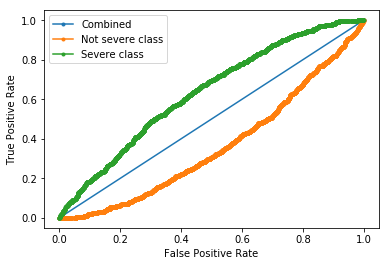

In [62]:
#lgb = LGBMClassifier(num_leaves=50, max_depth=5,objective='binary')
lgb = LGBMClassifier(learning_rate=0.1,num_leaves=10, min_data_in_leaves=1000,max_depth=5,objective='binary')

model = lgb.fit(x_train,y_train)
prediction = model.predict(x_test)

acc = accuracy_score(y_test,prediction)
print (acc)
prc = precision_score(y_test,prediction,average='micro')
print (prc)
rec = recall_score(y_test,prediction,average='micro')
print (rec)
f1 = f1_score(y_test,prediction,average='micro')
print (f1)
pd.Series(prediction).value_counts()

print (classification_report(y_test,prediction,target_names=['Not Severe','Severe']))
tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
print (tn, fp, fn, tp)

#AUC
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs_pos = lr_probs[:,1]
lr_probs_neg = lr_probs[:,0]

# calculate scores
lr_auc = roc_auc_score(y_test, prediction)
lr_auc_pos = roc_auc_score(y_test, lr_probs_pos)
lr_auc_neg = roc_auc_score(y_test, lr_probs_neg)

# summarize scores
print('Combined ROC AUC=%.3f' % (lr_auc))
print('Severe class ROC AUC=%.3f' % (lr_auc_pos))
print('Not severe class ROC AUC=%.3f' % (lr_auc_neg))

lr_fpr, lr_tpr, thresh = roc_curve(y_test, prediction)
lr_fpr_neg, lr_tpr_neg, thresh = roc_curve(y_test, lr_probs[:,0])
lr_fpr_pos, lr_tpr_pos, thresh = roc_curve(y_test, lr_probs_pos)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.', label='Combined')
plt.plot(lr_fpr_neg, lr_tpr_neg, marker='.', label='Not severe class')
plt.plot(lr_fpr_pos, lr_tpr_pos, marker='.', label='Severe class')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Grid search for time split data

In [59]:
from sklearn.model_selection import GridSearchCV

# Create param grid.
params = {'max_depth' : [5],
    'num_leaves':[10,30,50],
         'learning_rate':[0.001,0.003,0.005,0.01,0.1],
         'min_data_in_leaf':[1000,2000,5000,10000,50000],
         'objective':['binary'],
         }

# Create grid search object
lgb = LGBMClassifier()
clf = GridSearchCV(lgb, param_grid = params, cv = 5, verbose=True, n_jobs=-1,scoring='roc_auc')

# Fit on data

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  6.1min finished


In [60]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_data_in_leaf': 1000,
 'num_leaves': 10,
 'objective': 'binary'}

In [61]:
clf.best_score_

0.6459449131854915

In [65]:
print (model.feature_importances_)
print (x_train.columns)

[ 25  93  81  99 164 220 168  50]
Index(['Address Type', 'Junction Type', 'Month', 'Date', 'Hour', 'Speed',
       'Road Length', 'Day of the Week'],
      dtype='object')


### Misclassification error

In [68]:
lr_probs = model.predict_proba(x_test)
predictions = (lr_probs[:,1]>0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
error_rate = (fp+fn)/(tp+fp+tn+fn)
print (error_rate)

0.016525712063769807


In [211]:
predictions = (lr_probs[:,1]>0.02).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
error_rate = (fp+fn)/(tp+fp+tn+fn)
acc = accuracy_score(y_test,predictions)
print ("Misclassification error: ",error_rate)
print ("Accuracy: ",acc)
print ("TN: ",tn)
print ("FP: ",fp)
print ("FN: ",fn)
print ("TP: ",tp)

Misclassification error:  0.2957760234394075
Accuracy:  0.7042239765605925
TN:  42771
FP:  17697
FN:  474
TP:  493


### Experiments

### Things that improved base model: 
- Removing *Neighborhood* variable -> AUC improved from 0.635 to 0.654
- Optimizing parameters using grid search => num_leaves=50, max_depth=5 -> AUC=0.659
- No change with lgb = LGBMClassifier(max_depth=5,min_data_in_leaf=1000,num_leaves=30,objective='binary')
- No change with max_depth=10,min_data_in_leaf=10000,num_leaves=30,objective='binary'
- Got worse at lgb = LGBMClassifier(learning_rate=0.01,max_depth=5,min_data_in_leaf=1000,num_leaves=30,objective='binary')
- Better model -> lgb = LGBMClassifier(num_leaves=10, max_depth=5,objective='binary') -> AUC=0.66
- Logistic regression with SMOTE. The ROC AUC was 0.629 but the combined AUC improved as well. Also, the intersection point for TP and FN significantly moved to the right which means that the threshold does not need to be adjusted as much to see a decent TP value. 
- Logistic regression with SMOTE did not improve much following grid search

### Additional notes

- Splitting by year did not appear to improve the model

- Determine misclassification error
- Plot curves of predictions with train and test data in order to find optimal point for compromise between over-fitting and under-fitting